# Is that audio?

Solution author: Asandei Stefan-Alexandru

Note: there were some technical issues with the task dataset, including data leakage. We are very sorry about this, and we will work more on task review in the future. This notebook does not get the best possible score, but we consider it is a great learning resource. We are releasing better Audio tasks in the coming rounds.

This notebook is very useful to teach about how to approach Audio tasks, including Data Processing and Models. 

In [ ]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset

In [17]:
root_path = "/home/stefan/ioai-prep/kits/is-that-audio-aicc-round-1"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

target_sr = 16000
batch_size = 32
epochs = 100

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# Data

In [18]:
train_csv = os.path.join(root_path, "train.csv")
test_csv = os.path.join(root_path, "test.csv")

train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

le = LabelEncoder()
train_df["label_enc"] = le.fit_transform(train_df["label"])
n_classes = len(le.classes_)

train_df[["path", "label", "label_enc"]].head()

,path,label,label_enc
0,./data/raw_audio/B/B_000051.wav,B_class_0,40
1,./data/raw_audio/B/B_000163.wav,B_class_0,40
2,./data/raw_audio/B/B_000061.wav,B_class_0,40
3,./data/raw_audio/B/B_000026.wav,B_class_0,40
4,./data/raw_audio/A/A_000026.wav,A_class_26,13


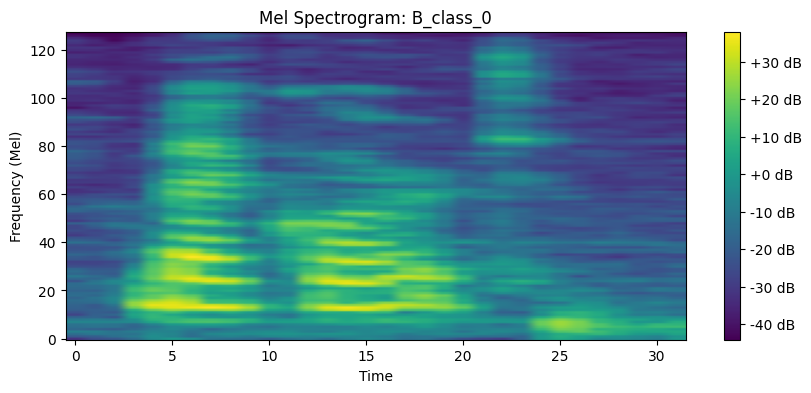

In [19]:
def get_sample_melspec(path):
    full_path = os.path.join(root_path, path.lstrip("./"))
    waveform, sr = torchaudio.load(full_path)
    if sr != target_sr:
        waveform = torchaudio.transforms.Resample(sr, target_sr)(waveform)
    mel_tf = torchaudio.transforms.MelSpectrogram(
        sample_rate=target_sr, n_mels=128, n_fft=2048, hop_length=512
    )
    melspec = torchaudio.transforms.AmplitudeToDB()(mel_tf(waveform))
    return melspec.squeeze().numpy()


sample_path = train_df.iloc[0]["path"]
sample_mel = get_sample_melspec(sample_path)

plt.figure(figsize=(10, 4))
plt.imshow(sample_mel, aspect="auto", origin="lower")
plt.title(f"Mel Spectrogram: {train_df.iloc[0]['label']}")
plt.xlabel("Time")
plt.ylabel("Frequency (Mel)")
plt.colorbar(format="%+2.0f dB")
plt.show()

In [20]:
def extract_melspec(path):
    try:
        full_path = os.path.join(root_path, path.lstrip("./"))
        if not os.path.isfile(full_path):
            return np.zeros((1, 128, 256), dtype=np.float32)

        waveform, sr = torchaudio.load(full_path)
        waveform = waveform.to(torch.float32)
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)
        if sr != target_sr:
            waveform = torchaudio.transforms.Resample(sr, target_sr)(waveform)

        mel_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=target_sr, n_mels=128, n_fft=2048, hop_length=512
        )
        melspec = torchaudio.transforms.AmplitudeToDB()(mel_transform(waveform))
        melspec_np = melspec.squeeze(0).numpy()

        # Standardize shape to (128, 256)
        if melspec_np.shape[1] < 256:
            melspec_np = np.pad(melspec_np, ((0, 0), (0, 256 - melspec_np.shape[1])))
        else:
            melspec_np = melspec_np[:, :256]

        return melspec_np.astype(np.float32)
    except Exception as e:
        warnings.warn(f"Error processing {path}: {e}")
        return np.zeros((128, 256), dtype=np.float32)


class AudioDataset(Dataset):
    def __init__(self, paths, labels):
        self.paths = paths
        self.labels = labels

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        melspec = extract_melspec(self.paths[idx])
        melspec = (melspec - melspec.mean()) / (melspec.std() + 1e-5)
        return torch.from_numpy(melspec).unsqueeze(0), torch.tensor(
            self.labels[idx], dtype=torch.long
        )

In [21]:
X_train, X_val, y_train, y_val = train_test_split(
    train_df["path"].values,
    train_df["label_enc"].values,
    test_size=0.2,
    random_state=seed,
    shuffle=True,
)

train_loader = DataLoader(
    AudioDataset(X_train, y_train), batch_size=batch_size, shuffle=True
)
val_loader = DataLoader(
    AudioDataset(X_val, y_val), batch_size=batch_size, shuffle=False
)

len(train_loader), len(val_loader)

(5, 2)

In [22]:
batch = next(iter(train_loader))
[b.shape for b in batch]

[torch.Size([32, 1, 128, 256]), torch.Size([32])]

# Model

In [23]:
class AudioCNN(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(512 * 8 * 16, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, n_classes),
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

In [24]:
model = AudioCNN(n_classes).to(device)

model(batch[0].to(device)).shape

torch.Size([32, 41])

# Training

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

best_val_acc = 0.0
patience = 20
patience_counter = 0

In [28]:
history = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for specs, labels in train_loader:
        specs, labels = specs.to(device), labels.to(device)

        outputs = model(specs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for specs, labels in val_loader:
            specs, labels = specs.to(device), labels.to(device)
            outputs = model(specs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = correct / total
    scheduler.step()
    history.append(
        {"epoch": epoch + 1, "loss": total_loss / len(train_loader), "val_acc": val_acc}
    )

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        patience_counter += 1

    if patience_counter >= patience:
        break

pd.DataFrame(history).tail()

,epoch,loss,val_acc
16,17,0.067966,0.72973
17,18,0.126580,0.72973
18,19,0.115404,0.72973
19,20,0.094009,0.72973
20,21,0.077025,0.72973


# Submission

In [29]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

test_ds = AudioDataset(test_df["path"].values, np.zeros(len(test_df)))
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

predictions = []
with torch.no_grad():
    for specs, _ in test_loader:
        outputs = model(specs.to(device))
        predictions.extend(torch.max(outputs, 1)[1].cpu().numpy())

submission = pd.DataFrame(
    {"id": test_df["id"].values, "label": le.inverse_transform(predictions)}
)
submission.to_csv(os.path.join(root_path, "submission.csv"), index=False)

submission.head()

,id,label
0,B_000176,B_class_0
1,B_000073,B_class_0
2,B_000109,B_class_0
3,A_000049,A_class_45
4,B_000003,B_class_0
